# Bad quantisation for Llama-8B under RMS scaling

We noticed that `F.Scaled(3, "int", Q.BFLOAT16, (1, None), "rms", "optimal")` performs particularly badly for `meta-llama/Llama-3.1-8B`. This notebook debugs the cause.

In [ ]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import safetensors.torch
import torch

import block_formats.experiments as E
import block_formats.experiments.token_prediction as ET
import block_formats.fit as F
import block_formats.model_quantisation as M
import block_formats.quantisation as Q

matplotlib.rcParams.update({"axes.spines.top": False, "axes.spines.right": False, "legend.frameon": False})
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
model = E.RequantisableModel.load("meta-llama/Llama-3.1-8B", DEVICE, torch.bfloat16)
data = ET.Dataset.load_wikitext(model.model, 4096, 1, 128, 16)
data1 = ET.Dataset.load_wikitext(model.model, 4096, 1, 128, 1)
data.evaluate(model.model)

Loading checkpoint shards: 100%|██████████| 4/4 [02:01<00:00, 30.45s/it]


{'cross_entropy': tensor([1.7383, 2.2270, 1.3403, 1.8751, 1.8488, 1.5933, 1.8925, 1.7227, 1.4836,
         1.5295, 1.7491, 1.8509, 1.4257, 1.7619, 1.7993, 1.9820],
        device='cuda:0'),
 'kl_div': tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        device='cuda:0')}

In [ ]:
model.reset()
r = M.quantise_2d_fixed(model.model, F.Scaled(3, "int", Q.BFLOAT16, (1, None), "rms", "optimal"))
data.evaluate(model.model)

{'cross_entropy': tensor([4.5721, 4.8556, 4.0670, 4.8181, 4.8043, 4.5317, 4.6443, 4.9782, 5.2783,
         4.9839, 3.6920, 4.7815, 4.3863, 4.7546, 4.2170, 4.6042],
        device='cuda:0'),
 'kl_div': tensor([2.7393, 2.5580, 2.6648, 2.9427, 2.8081, 2.9322, 2.6374, 3.1669, 3.7476,
         3.4008, 1.8965, 2.8736, 2.9199, 2.9539, 2.3808, 2.5107],
        device='cuda:0')}

In [ ]:
# Identify the type of layer that is the problem
model.reset()
r = M.quantise_2d_fixed(model.model, F.Scaled(3, "int", Q.BFLOAT16, (1, None), "rms", "optimal"), ignore=("down_proj",))
data.evaluate(model.model)

{'cross_entropy': tensor([1.8590, 2.3826, 1.4446, 1.9860, 2.0133, 1.6958, 2.0281, 1.8707, 1.6753,
         1.6453, 1.8412, 2.0139, 1.5882, 1.8796, 1.9574, 2.1154],
        device='cuda:0'),
 'kl_div': tensor([0.1206, 0.1461, 0.1109, 0.1313, 0.1529, 0.1084, 0.1265, 0.1560, 0.2027,
         0.1290, 0.0965, 0.1522, 0.1651, 0.1141, 0.1413, 0.1263],
        device='cuda:0')}

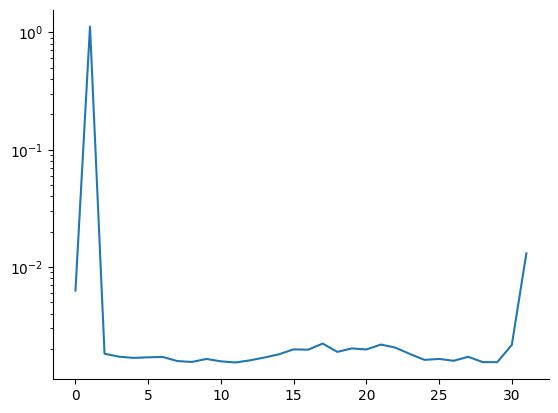

In [6]:
# Identify the specific tensor
kl_by_layer = []
for n, layer in enumerate(model.model.model.layers):
    model.reset()
    M.quantise_parameter_(layer.mlp.down_proj.weight, F.Scaled(3, "int", Q.BFLOAT16, (1, None), "rms", "optimal"))
    kl_by_layer.append(data1.evaluate(model.model)["kl_div"].mean())
_, ax = plt.subplots()
ax.plot(torch.stack(kl_by_layer).cpu())
ax.set_yscale("log")

In [51]:
p = model.model.model.layers[1].mlp.down_proj.weight

def test(fmt: Q.TensorFormat) -> None:
    model.reset()
    q = fmt.quantise(p.detach())
    rmse = Q.rmse_norm(p, q)
    p.data[...] = q
    kl_div = data1.evaluate(model.model)["kl_div"].mean()
    print(f"{str(fmt):>40} | {rmse.item():<10.2f} | {kl_div.item():<10.2f}")

print(f"{'fmt':>40} | {'rmse':<10} | {'kl_div':<10}")
test(Q.LinearScalingFormat(Q.parse("E2M0"), Q.BFLOAT16, (1, None), "rms"))
test(Q.LinearScalingFormat(Q.parse("E2M0"), Q.BFLOAT16, (1, None), "absmax"))
test(Q.ChannelAndSparseFormat(Q.parse("E2M0"), Q.BFLOAT16, (0,), Q.BFLOAT16, 1e-7))
test(Q.RandomRotationFormat(Q.LinearScalingFormat(Q.parse("E2M0"), Q.BFLOAT16, (1, None), "rms"), (0,), 123))

                                     fmt | rmse       | kl_div    
                  E2M0{1,*:BFLOAT16:rms} | 0.23       | 9.90      
               E2M0{1,*:BFLOAT16:absmax} | 0.35       | 0.16      
  E2M0{dim=(0,):BFLOAT16}+BFLOAT16{0.0%} | 0.23       | 0.06      
          E2M0{1,*:BFLOAT16:rms}{rot[0]} | 0.22       | 0.36      


In [67]:
fisher = safetensors.torch.load_file("../out/fisher/meta-llama--Llama-3.1-8B.safetensors")
display(pd.DataFrame.from_records([dict(parameter=p, fisher=f.sum().item()) for p, f in fisher.items()]).sort_values("fisher", ascending=False).head(5))

,parameter,fisher
9,model.layers.1.mlp.down_proj.weight,58880.0
0,lm_head.weight,9984.0
8,model.layers.0.self_attn.v_proj.weight,5152.0
177,model.layers.31.mlp.down_proj.weight,4576.0
15,model.layers.1.self_attn.v_proj.weight,3824.0
